In [1]:
# MODULES
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import pandas as pd
import os

def prepare_denoise_data(ndat_train=256, ndat_valid=64, ndat_test=5, save_csv=False, directory=os.getcwd(), batch_size=1, plot=False):
    nts = 1024
    ts = np.arange(0, nts, 1)

    def dataset(ts, ndat):
        """Create dataset, case study: sin convolved with gaussian."""
        train_dataset = []
        parameters = []  # Store parameters for each trace
        for idat in range(ndat):
            tssig = random.uniform(512-100, 512+100)
            omega = random.uniform(0.01, 0.1)
            sigma = random.uniform(200, 800)
            trace = np.sin(2. * np.pi * (ts - tssig) * omega) * np.exp(-(ts - tssig) ** 2 / sigma)
            train_dataset.append([trace])
            parameters.append((tssig, omega, sigma))
            # Save data to csv if save_csv is True
            if save_csv:
                df = pd.DataFrame({'Time': ts, 'Trace': trace})
                filename = os.path.join(directory, f'trace_data_{idat}.csv')
                df.to_csv(filename, index=False)
                print(f'Data saved to {filename}')

        return torch.tensor(np.array(train_dataset), dtype=torch.float32), parameters

    train_ds_tensor, train_params = dataset(ts, ndat_train)
    valid_ds_tensor, valid_params = dataset(ts, ndat_valid)
    test_ds_tensor, test_params = dataset(ts, ndat_test)
    # Visualize data
    if plot:
        for i in range(ndat_test):
            fig, axs = plt.subplots(figsize=(16, 4))
            trace = np.array(train_ds_tensor)[i, 0, :]
            axs.plot(ts, trace, color='r', label=f'tssig={train_params[i][0]:.2f}, omega={train_params[i][1]:.5f}, sigma={train_params[i][2]:.2f}')
            axs.legend(loc='upper right')
            axs.set_title('Trace')
            axs.set(xlabel='time', ylabel='Amplitude')
            plt.show()

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_ds_tensor, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_ds_tensor, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_ds_tensor, batch_size=1, shuffle=True)

    return train_loader, valid_loader, test_loader


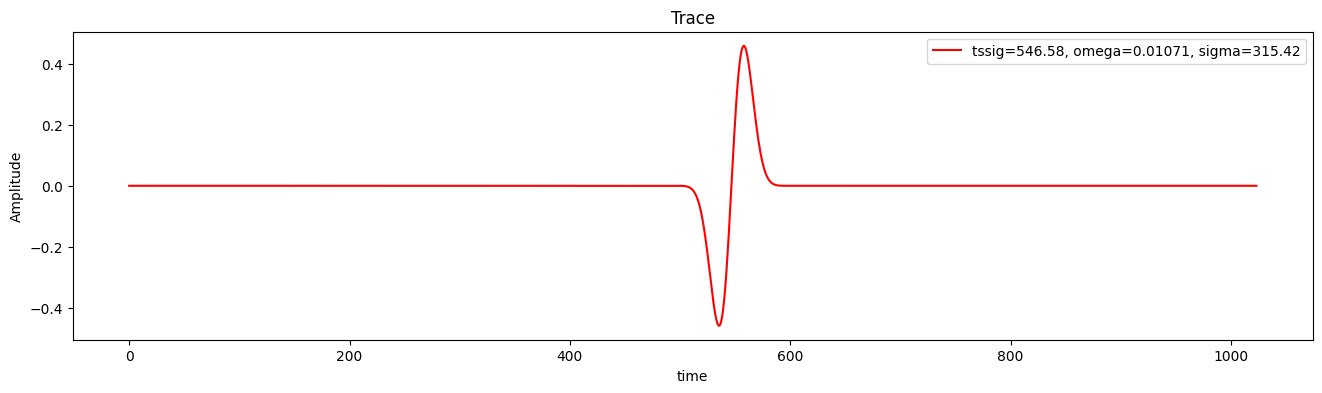

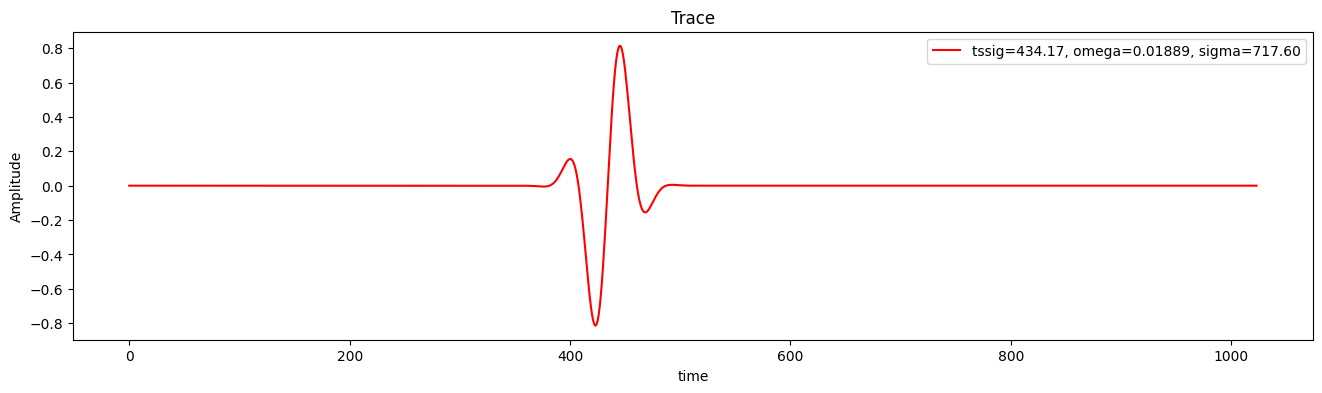

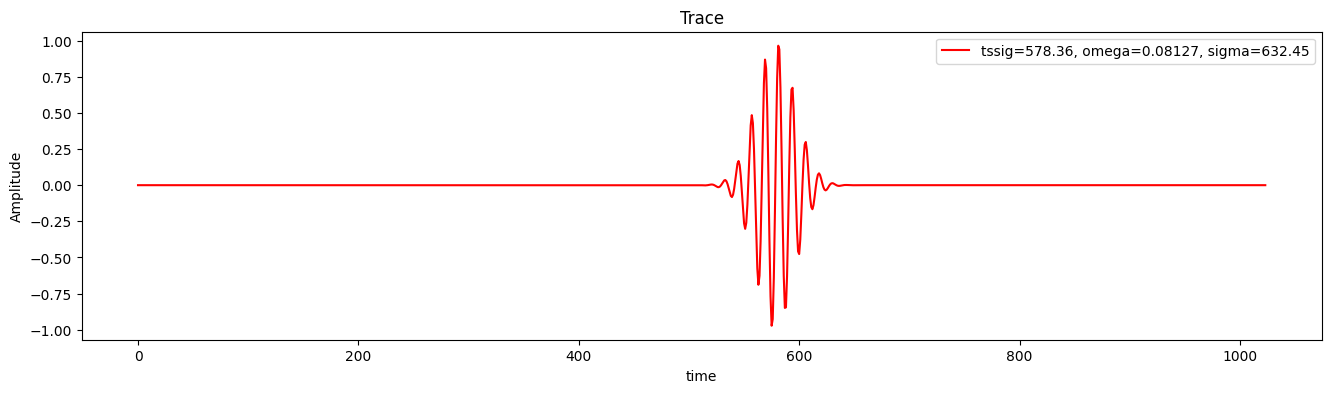

(<torch.utils.data.dataloader.DataLoader at 0x7c3bc0c13670>,
 <torch.utils.data.dataloader.DataLoader at 0x7c3ae637ec20>)

In [2]:
prepare_denoise_data(ndat_train=256, ndat_valid=64, ndat_test=3, save_csv=False, directory=os.getcwd(), batch_size=1,plot = True )

cuda:0
Epoch [1/10], Train Loss: 1.9126, Test Loss: 0.0015
Epoch [2/10], Train Loss: 0.0014, Test Loss: 0.0022
Epoch [3/10], Train Loss: 0.0062, Test Loss: 0.0019
Epoch [4/10], Train Loss: 0.0016, Test Loss: 0.0016
Epoch [5/10], Train Loss: 0.0015, Test Loss: 0.0013
Epoch [6/10], Train Loss: 0.0013, Test Loss: 0.0013
Epoch [7/10], Train Loss: 0.0011, Test Loss: 0.0012
Epoch [8/10], Train Loss: 0.0010, Test Loss: 0.0010
Epoch [9/10], Train Loss: 0.0008, Test Loss: 0.0007
Epoch [10/10], Train Loss: 0.0007, Test Loss: 0.0006


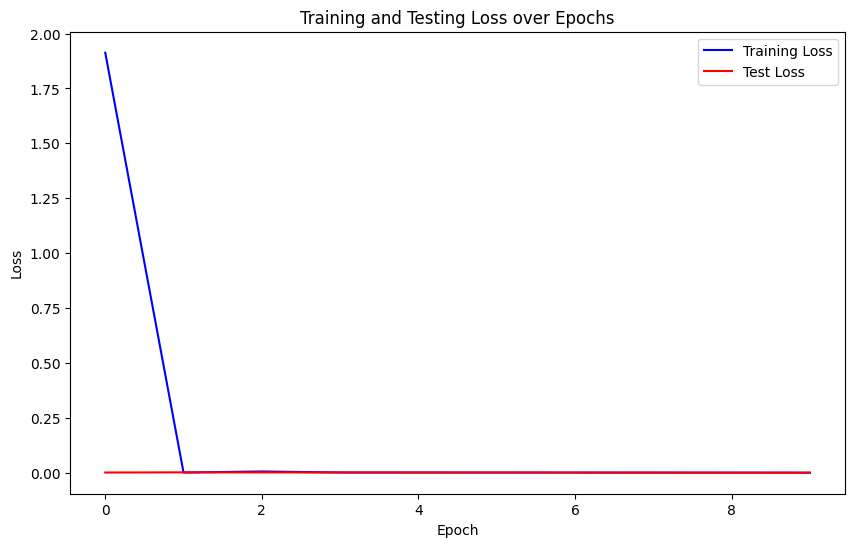

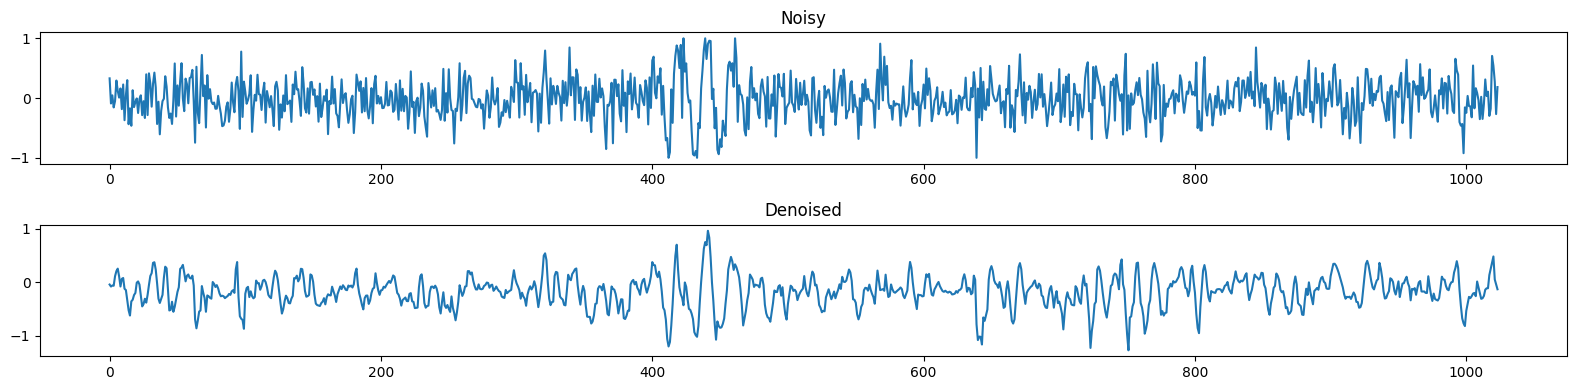

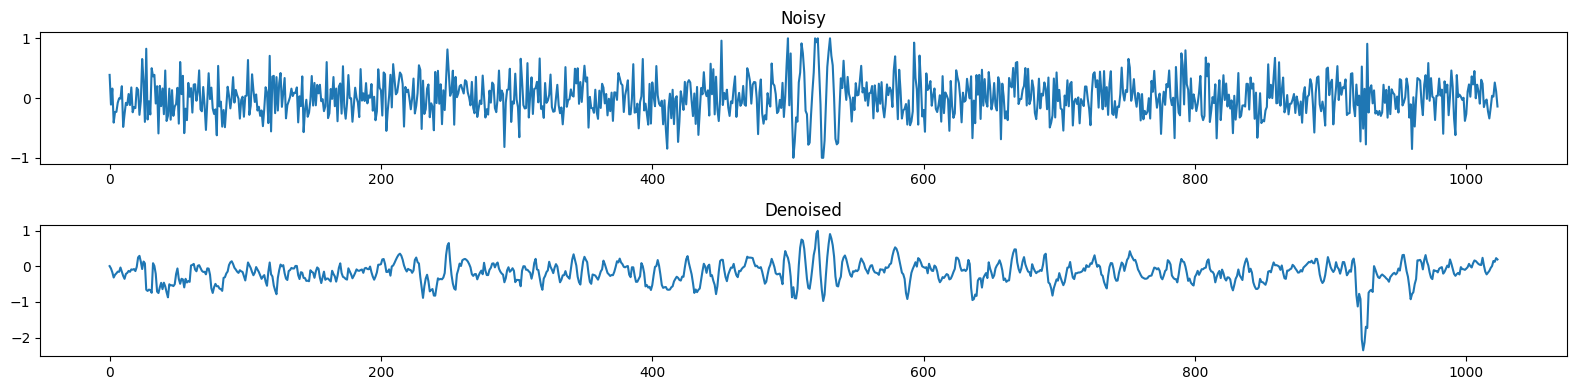

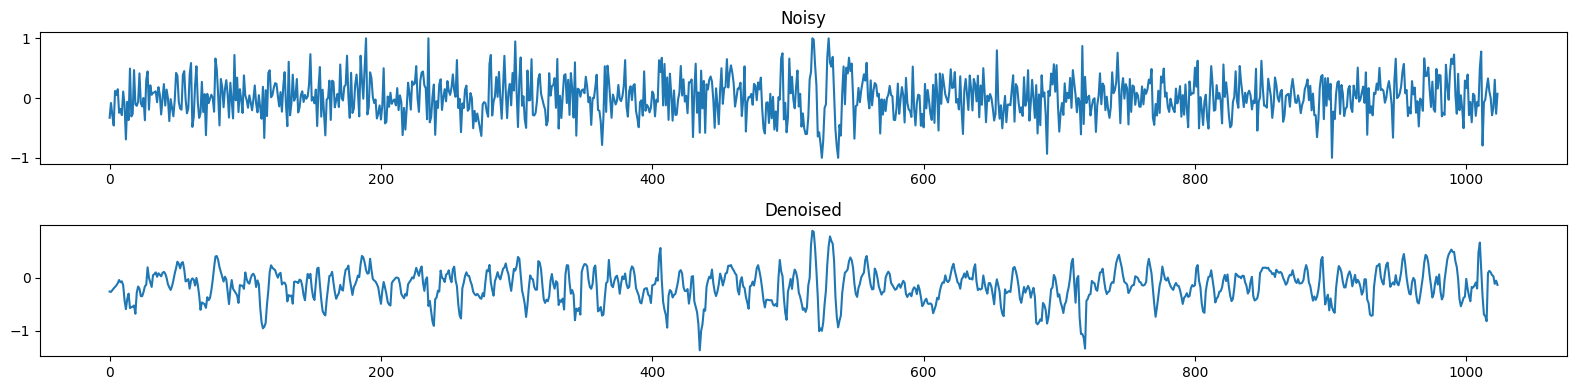

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

device = "cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device = "cuda:0"
print(device)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def add_noise(inputs, noise_factor=0.5):
    """Add noise to traces."""
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, -1., 1.)
    return noisy

criterion = nn.MSELoss()

def initialize_model(learning_rate=0.001):
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer


model, optimizer = initialize_model()

train_loader, valid_loader, test_loader = prepare_denoise_data()

train_losses = []
test_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Evaluation Phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

# Testing the denoising capability
model.eval()

# Check if test_loader.dataset is a Tensor or TensorDataset
if isinstance(test_loader.dataset, TensorDataset):
    noisy_test_dataset = add_noise(test_loader.dataset.tensors[0])
else:
    noisy_test_dataset = add_noise(test_loader.dataset)

noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=1, shuffle=True)

# Storing original, noisy, and denoised outputs for visualization
originals, noisy_data, denoised_data = [], [], []
with torch.no_grad():
    for data in noisy_test_loader:
        data = data.to(device)
        outputs = model(data)
        noisy_data.append(data.cpu().numpy())
        denoised_data.append(outputs.cpu().numpy())

# Visualize original vs noisy vs denoised for a few examples
for i in range(3):
    plt.figure(figsize=(16, 4))
    plt.subplot(2, 1, 1)
    plt.plot(noisy_data[i][0, 0, :])
    plt.title("Noisy")
    plt.subplot(2, 1, 2)
    plt.plot(denoised_data[i][0, 0, :])
    plt.title("Denoised")
    plt.tight_layout()
    plt.show()